###### Importing Python Librairies

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.utils import resample
from scipy import stats
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

***

# Gather & Assess

#### Reading Data

In [2]:
triage_df=pd.read_excel('data.xlsx', sheet_name="Triage", engine='openpyxl')
triage_df.head()

,Unnamed: 0,ID,First Name,Last Name,Date of Initial Call,Outcome of Initial Call,Learned about services through:,Sex,Age
0,JohnDoe,1,John,Doe,2021-02-01,Appointment Given,Instagram,Male,23.0
1,SamanthaSmith,2,Samantha,Smith,2021-02-02,Pending Slot Availability,NGO,Female,21.0
2,AdamHorn,3,Adam,Horn,2021-02-03,Pending Slot Availability,NGo,Male,44.0
3,JoeWhite,4,Joe,White,2021-02-04,Appointment not Given - Services not Available,Friend,Male,32.0
4,AliceMurray,5,Alice,Murray,2021-02-05,Appointment Given,Lifeline,Female,NaN


***

In [3]:
appointment_df=pd.read_excel('data.xlsx', sheet_name="Appointment Information", engine='openpyxl')
appointment_df.head()

,Name,Surname,Date,Visit Status,Practitioner Type,PHQ-9
0,Alexander,SCOTT,2021-03-10 00:00:00,Seen,Psychiatrist,21.0
1,Alfie,MURRAY,2021-03-10 00:00:00,Seen,Psychiatrist,23.0
2,Alfie,Murray,2021-03-22 00:00:00,seen,Social Worker,22.0
3,Alice,Murray,2021-03-01 00:00:00,Seen,Nurse,NaN
4,Alice,Murray,2021-03-28 00:00:00,seen,Psychiatrist,23.0


***

#### Data Understanding & Cleaning

###### Triage data

In [4]:
triage_df.dtypes

Unnamed: 0                                 object
ID                                          int64
First Name                                 object
Last Name                                  object
Date of Initial Call               datetime64[ns]
Outcome of Initial Call                    object
Learned about services through:            object
Sex                                        object
Age                                       float64
dtype: object

In [5]:
triage_df.columns

Index(['Unnamed: 0', 'ID', 'First Name', 'Last Name', 'Date of Initial Call',
       'Outcome of Initial Call', 'Learned about services through:', 'Sex',
       'Age'],
      dtype='object')

In [6]:
#drop unecessary colums

triage_df.drop(['Unnamed: 0', 'ID'], axis=1, inplace=True) 

In [7]:
#search for full name duplicates(i.e. duplicated rows)

triage_df[triage_df.duplicated(['First Name','Last Name'], keep=False)]

,First Name,Last Name,Date of Initial Call,Outcome of Initial Call,Learned about services through:,Sex,Age
8,Mike,Good,2021-02-06,Appointment Given,Lifeline,Male,38.0
9,Mike,Good,2021-02-06,Appointment Given,Lifeline,Male,6.0


the patient's entry for Mike Good is duplicated with different age, it is observed that Mike learned about the services via the lifeline, which leads to tthe assumption that Mike cannot be a minor to dial the number and converse with a social worker (Unless Mike's Parents were talking over the phone). Nevertheless, the row where Mike is 6 yrs old will be deleted.

In [8]:
# delete the row of 6 years old Mike Good

triage_df.drop(9, inplace=True)

In [9]:
# rename columns

triage_df.columns = ['name', 'surname', 'call date', 'call outcome', 'services awerness via', 'sex', 'age']

In [10]:
# lowere all strings in the dataframe

triage_df = triage_df.applymap(lambda s:s.lower().strip() if type(s) == str else s)

In [11]:
# create a full name column from the name and surname columns 
triage_df['full name'] = triage_df.name +' '+ triage_df.surname
triage_df.head()

,name,surname,call date,call outcome,services awerness via,sex,age,full name
0,john,doe,2021-02-01,appointment given,instagram,male,23.0,john doe
1,samantha,smith,2021-02-02,pending slot availability,ngo,female,21.0,samantha smith
2,adam,horn,2021-02-03,pending slot availability,ngo,male,44.0,adam horn
3,joe,white,2021-02-04,appointment not given - services not available,friend,male,32.0,joe white
4,alice,murray,2021-02-05,appointment given,lifeline,female,NaN,alice murray


In [12]:
# check gender variable values 
triage_df.sex.unique()

array(['male', 'female'], dtype=object)

In [13]:
# descirptive statistics of Age variable (gender segragated)
triage_df.age[triage_df.sex == 'male'].describe()

count    35.000000
mean     39.000000
std      23.079148
min       3.000000
25%      22.000000
50%      38.000000
75%      55.000000
max      97.000000
Name: age, dtype: float64

In [14]:
# descirptive statistics of Age variable (gender segragated)
triage_df.age[triage_df.sex == 'female'].describe()

count      23.000000
mean      267.565217
std      1107.194564
min         6.000000
25%        27.000000
50%        37.000000
75%        45.000000
max      5346.000000
Name: age, dtype: float64

In [15]:
# Null count within the Age variable sample 
triage_df.age[triage_df.sex == 'male'].isna().sum()

1

In [16]:
# Null count within the Age variable sample 
triage_df.age[triage_df.sex == 'female'].isna().sum()

2

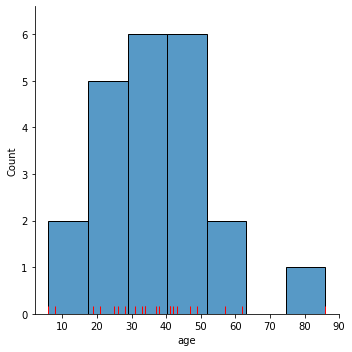

In [17]:
# visual exploration of the distribution of age for females, and signling out the irregular age 

sns.displot(triage_df.age[(triage_df.sex == 'female') & (triage_df.age < 120)], 
            kde=False, rug=True, rug_kws={'color':'red'});

It is observed that most female tend to be in the age range of 20 to mid-60's with few exceptions outside that range, and more concnetrated between 30 and 50 

In [18]:
# exploring females with age outside common range
triage_df[(triage_df.age < 14) & (triage_df.sex =='female')]

,name,surname,call date,call outcome,services awerness via,sex,age,full name
11,fionna,grant,2021-02-07,pending slot availability,sfriends,female,6.0,fionna grant
14,sophie,lard,2021-02-08,appointment given,fam,female,8.0,sophie lard


In [19]:
triage_df[(triage_df.age > 70) & (triage_df.sex =='female')]

,name,surname,call date,call outcome,services awerness via,sex,age,full name
47,sophia,mitchell,2021-02-24,appointment not given - services not available,ngo,female,5346.0,sophia mitchell
52,rosie,stevenson,2021-02-24,pending slot availability,family,female,86.0,rosie stevenson


In [20]:
# droping a row with an unusual range, furthermore an appointment was not given 
# (can be readdressed later with no services data if available)
triage_df.drop(47, inplace=True)

***

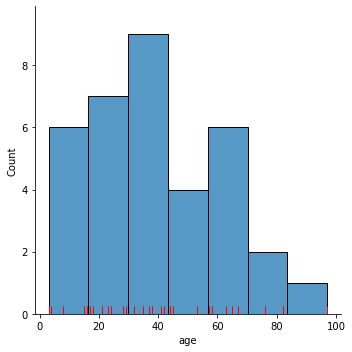

In [21]:
# visual exploration of the distribution of age for males

sns.displot(triage_df.age[(triage_df.sex == 'male')], kde=False, rug=True, rug_kws={'color':'red'});

In [22]:
triage_df[(triage_df.age < 14) & (triage_df.sex =='male')]

,name,surname,call date,call outcome,services awerness via,sex,age,full name
5,gavin,wolff,2021-02-06,appointment given,ngo,male,8.0,gavin wolff
10,sean,adam,2021-02-06,pending slot availability,family,male,3.0,sean adam
23,peter,loyd,2021-02-11,pending slot availability,lifeline,male,4.0,peter loyd
42,theo,young,2021-02-21,pending slot availability,ngo,male,4.0,theo young


It is obvious from the distribution of the age variable for males that the common range lies between 17/18 and mid-40's. Furthermore, some age values doesnt fit taking into context the society and the taboo surrounding mental health, it is assumed that at very young age, it is quite improbable to communicate clealry, and Oriental/meditarenean state of mind as parents wouldn't be much open or willing to consider a mental health issue with their childs, more of (tantrums, spoiled...). It is why it can be assumed that very young ages (3,4) must be missing a digit more like minors at the age of 14 and 13 since some heard of the services via an ngo/lifeline wich is improbable for a child at 3 yrs old

In [23]:
triage_df.loc[10, 'age'] = 13 # replacing male age of 3 to 13 yrs old 

In [24]:
indices = [23,42]
triage_df.loc[indices, 'age'] = 14  # replacing male age of 4 to 14 yrs old 

In [25]:
triage_df[(triage_df.age > 70) & (triage_df.sex =='male')]

,name,surname,call date,call outcome,services awerness via,sex,age,full name
12,damon,hart,2021-02-07,appointment given,ngo,male,76.0,damon hart
16,michael,black,2021-02-08,appointment given,family,male,97.0,michael black
31,harris,thomson,2021-02-13,appointment given,lifeline,male,82.0,harris thomson


Michael Black at the age of 97, taking in consideration the society and the geogrphical location, habbit, ect, very senior age. it is doubtful that the age 97 is correct, most seniors at that age have many more severe health difficulties, it is quite improbable by assumptions and a bit of domain knowledge. 

***

Categrocial Variables exploration and assessment in triage data

In [26]:
triage_df['services awerness via'].unique()

array(['instagram', 'ngo', 'friend', 'lifeline', 'private psychologist',
       'family', 'sfriends', 'fam', 'friend sarah', 'tv', 'facebook',
       'saw on news', 'twitter', 'cousin', nan, 'radio', 'doctor',
       'awareness booth', 'sister'], dtype=object)

In [27]:
# code block to regroup similar categories as 'close entourage' 

triage_df['services awerness via'] = np.where((triage_df['services awerness via'].str.contains('frie', regex=False))|
                                       (triage_df['services awerness via'].str.contains('fam', regex=False))|
                                       (triage_df['services awerness via'].str.contains('sist', regex=False))|
                                       (triage_df['services awerness via'].str.contains('cous', regex=False)),
                                              'close entourage',triage_df['services awerness via'])

In [28]:
# code block to regroup similar categories as audiovisual = Tv ('saw on on news, 'Tv)

triage_df['services awerness via'] = np.where((triage_df['services awerness via'].str.contains('news', regex=False))|
                                       (triage_df['services awerness via'].str.contains('tv', regex=False)),
                                       'television',triage_df['services awerness via'])

In [29]:
# code block to regroup similar categories as 'private practitioner'

triage_df['services awerness via'] = np.where((triage_df['services awerness via'].str.contains('doc', regex=False))|
                                               (triage_df['services awerness via'].str.contains('psych', regex=False)),
                                              'private practitioner',
                                              triage_df['services awerness via'])

In [30]:
triage_df['services awerness via'].unique()

array(['instagram', 'ngo', 'close entourage', 'lifeline',
       'private practitioner', 'television', 'facebook', 'twitter', nan,
       'radio', 'awareness booth'], dtype=object)

social media various categories will not be regrouped, it is crucial for further analysis of more ad and marketing efficacity and platfroms that are more outreaching (depending the age range of callers of course)

***

#### Appointment Information data

In [31]:
appointment_df.head()

,Name,Surname,Date,Visit Status,Practitioner Type,PHQ-9
0,Alexander,SCOTT,2021-03-10 00:00:00,Seen,Psychiatrist,21.0
1,Alfie,MURRAY,2021-03-10 00:00:00,Seen,Psychiatrist,23.0
2,Alfie,Murray,2021-03-22 00:00:00,seen,Social Worker,22.0
3,Alice,Murray,2021-03-01 00:00:00,Seen,Nurse,NaN
4,Alice,Murray,2021-03-28 00:00:00,seen,Psychiatrist,23.0


In [32]:
appointment_df.dtypes

Name                  object
Surname               object
Date                  object
Visit Status          object
Practitioner Type     object
PHQ-9                float64
dtype: object

In [33]:
# renaming columns
appointment_df.columns =['name', 'surname', 'appointment date', 'status', 'practitioner', 'phq9']

In [34]:
# observing final rows 
appointment_df.loc[50:92]

,name,surname,appointment date,status,practitioner,phq9
50,James,Black,2021-03-17 00:00:00,Cancelled,Psychiatrist,NaN
51,Joshua,MCKENZIE,2021-03-16 00:00:00,seen,Psychologist,4.0
52,Leo,ANDERSON,2021-03-10 00:00:00,Seen,Psychologist,14.0
53,Mike,Good,"18 ,ARCH 2-21",No show,Psychiatrist,NaN
54,Leo,ANDERSON,2021-03-12 00:00:00,Seen,Psychiatrist,11.0
55,James,STEWART,2021-03-22 00:00:00,No show,Nurse,NaN
56,Leo,ANDERSON,2021-03-28 00:00:00,seen,Psychologist,13.0
57,Leon,Grave,2021-03-01 00:00:00,Seen,Psychiatrist,3.0
58,Leon,Grave,2021-03-07 00:00:00,Seen,Psychiatrist,33.0
59,Lewis,ROBERTSON,2021-03-09 00:00:00,Seen,Psychologist,24.0


In [35]:
# droping rows will all null values 

appointment_df.dropna(how='all', inplace=True)

In [36]:
# closer look at the appointment date column
appointment_df['appointment date'].unique()

array([datetime.datetime(2021, 3, 10, 0, 0),
       datetime.datetime(2021, 3, 22, 0, 0),
       datetime.datetime(2021, 3, 1, 0, 0),
       datetime.datetime(2021, 3, 28, 0, 0),
       datetime.datetime(2021, 3, 2, 0, 0),
       datetime.datetime(2021, 3, 11, 0, 0),
       datetime.datetime(2021, 3, 13, 0, 0),
       datetime.datetime(2021, 3, 3, 0, 0),
       datetime.datetime(2021, 3, 30, 0, 0),
       datetime.datetime(2021, 3, 7, 0, 0),
       datetime.datetime(2021, 3, 4, 0, 0),
       datetime.datetime(2021, 3, 31, 0, 0),
       datetime.datetime(2021, 3, 9, 0, 0),
       datetime.datetime(2021, 3, 23, 0, 0),
       datetime.datetime(2021, 3, 8, 0, 0),
       datetime.datetime(2021, 3, 24, 0, 0),
       datetime.datetime(2021, 3, 15, 0, 0),
       datetime.datetime(2021, 3, 16, 0, 0),
       datetime.datetime(2021, 3, 29, 0, 0),
       datetime.datetime(2021, 3, 17, 0, 0), '18 ,ARCH 2-21',
       datetime.datetime(2021, 3, 12, 0, 0), '16/03/201'], dtype=object)

In [37]:
type(appointment_df['appointment date'].loc[1]) # first entry date type 

datetime.datetime

In [38]:
type(appointment_df['appointment date'].loc[88]) # type of irregular date entry

str

In [39]:
# iterating through the date column and extracting the indices of irregular date type 

for index, row in appointment_df['appointment date'].iteritems():
    if type(row) == str:
        print(index, row)

53 18 ,ARCH 2-21
81 18 ,ARCH 2-21
88 16/03/201


In [40]:
# replacing date by correct type 

indices = [53,81]
appointment_df.loc[indices, 'appointment date'] = datetime.datetime(2021, 3, 18, 0, 0)
appointment_df.loc[88,'appointment date'] = datetime.datetime(2021, 3, 16, 0, 0)

In [41]:
# changing the apointment date type to the correct datetime type 

appointment_df['appointment date']= pd.to_datetime(appointment_df['appointment date'])

In [42]:
appointment_df.dtypes

name                        object
surname                     object
appointment date    datetime64[ns]
status                      object
practitioner                object
phq9                       float64
dtype: object

In [43]:
# lowering and stripping white spaces in string values in the dataframe

appointment_df = appointment_df.applymap(lambda s:s.lower().strip() if type(s) == str else s)

In [44]:
# creating a full name column

appointment_df['full name'] = appointment_df.name +' '+appointment_df.surname
appointment_df.head()

,name,surname,appointment date,status,practitioner,phq9,full name
0,alexander,scott,2021-03-10,seen,psychiatrist,21.0,alexander scott
1,alfie,murray,2021-03-10,seen,psychiatrist,23.0,alfie murray
2,alfie,murray,2021-03-22,seen,social worker,22.0,alfie murray
3,alice,murray,2021-03-01,seen,nurse,NaN,alice murray
4,alice,murray,2021-03-28,seen,psychiatrist,23.0,alice murray


In [45]:
# checking on status categorical variables unique values 

appointment_df.status.unique()

array(['seen', 'cancelled', 'no show', 'sen', 'cancelled no car',
       'cancelled -sick', 'een', 'last minute cancel', 'canceled',
       'seenn', 'wno shw', 'sick-cancel'], dtype=object)

In [46]:
# regoup adequate values to 'attended' categorical value 

appointment_df['status'] = np.where((appointment_df['status'].str.contains('sen', regex=False))|
                                    (appointment_df['status'].str.contains('een', regex=False)),'attended',
                                    appointment_df['status'])

In [47]:
# regoup adequate values to 'cancelled'
appointment_df['status'] = np.where((appointment_df['status'].str.contains('ancel', regex=False)),
                                    'cancelled',appointment_df['status'])

In [48]:
# regroup no show values 

appointment_df['status'] = np.where((appointment_df['status'].str.contains('no', regex=False)),
                                    'no show',appointment_df['status'])

In [49]:
appointment_df.status.unique()

array(['attended', 'cancelled', 'no show'], dtype=object)

In [50]:
appointment_df.practitioner.unique()

array(['psychiatrist', 'social worker', 'nurse', 'psychologist'],
      dtype=object)

***

###### Save the cleaned and restructured dataframes into csv files

In [51]:
triage_df.to_csv('triage.csv', index= False) #saving the dataframe into a csv file 'triage.csv'

In [52]:
pd.read_csv('triage.csv') #reading it back shows normal dataframe structure previously arranged

,name,surname,call date,call outcome,services awerness via,sex,age,full name
0,john,doe,2021-02-01,appointment given,instagram,male,23.0,john doe
1,samantha,smith,2021-02-02,pending slot availability,ngo,female,21.0,samantha smith
2,adam,horn,2021-02-03,pending slot availability,ngo,male,44.0,adam horn
3,joe,white,2021-02-04,appointment not given - services not available,close entourage,male,32.0,joe white
4,alice,murray,2021-02-05,appointment given,lifeline,female,NaN,alice murray
5,gavin,wolff,2021-02-06,appointment given,ngo,male,8.0,gavin wolff
6,leon,grave,2021-02-06,appointment given,private practitioner,male,18.0,leon grave
7,james,black,2021-02-06,appointment given,close entourage,male,37.0,james black
8,mike,good,2021-02-06,appointment given,lifeline,male,38.0,mike good
9,sean,adam,2021-02-06,pending slot availability,close entourage,male,13.0,sean adam


In [53]:
appointment_df.to_csv('appointment.csv', index= False) #saving the dataframe into a csv file 'appointment.csv'

In [54]:
pd.read_csv('appointment.csv') #reading it back shows normal dataframe structure previously arranged 

,name,surname,appointment date,status,practitioner,phq9,full name
0,alexander,scott,2021-03-10,attended,psychiatrist,21.0,alexander scott
1,alfie,murray,2021-03-10,attended,psychiatrist,23.0,alfie murray
2,alfie,murray,2021-03-22,attended,social worker,22.0,alfie murray
3,alice,murray,2021-03-01,attended,nurse,NaN,alice murray
4,alice,murray,2021-03-28,attended,psychiatrist,23.0,alice murray
...,...,...,...,...,...,...,...
85,lewis,robertson,2021-03-31,cancelled,psychiatrist,NaN,lewis robertson
86,alfie,murray,2021-03-31,cancelled,social worker,NaN,alfie murray
87,sophie,lard,2021-03-04,attended,nurse,23.0,sophie lard
88,sophie,lard,2021-03-16,attended,psychiatrist,NaN,sophie lard


***